In [1]:
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

https://towardsdatascience.com/trading-strategy-back-testing-with-backtrader-6c173f29e37f


https://www.backtrader.com/docu/quickstart/quickstart/

In [2]:
def plot(self, plotter=None, numfigs=1, iplot=True, start=None, end=None,
         width=16, height=9, dpi=300, tight=True, use=None, path=None,
         **kwargs):
    '''
    출처 : 
    수정해봄.

    Plots the strategies inside cerebro

    If ``plotter`` is None a default ``Plot`` instance is created and
    ``kwargs`` are passed to it during instantiation.

    ``numfigs`` split the plot in the indicated number of charts reducing
    chart density if wished

    ``iplot``: if ``True`` and running in a ``notebook`` the charts will be
    displayed inline

    ``use``: set it to the name of the desired matplotlib backend. It will
    take precedence over ``iplot``

    ``start``: An index to the datetime line array of the strategy or a
    ``datetime.date``, ``datetime.datetime`` instance indicating the start
    of the plot

    ``end``: An index to the datetime line array of the strategy or a
    ``datetime.date``, ``datetime.datetime`` instance indicating the end
    of the plot

    ``width``: in inches of the saved figure

    ``height``: in inches of the saved figure

    ``dpi``: quality in dots per inches of the saved figure

    ``tight``: only save actual content and not the frame of the figure
    '''
    if self._exactbars > 0:
        return

    if not plotter:
        from . import plot
        if self.p.oldsync:
            plotter = plot.Plot_OldSync(**kwargs)
        else:
            plotter = plot.Plot(**kwargs)

    # pfillers = {self.datas[i]: self._plotfillers[i]
    # for i, x in enumerate(self._plotfillers)}

    # pfillers2 = {self.datas[i]: self._plotfillers2[i]
    # for i, x in enumerate(self._plotfillers2)}
    import matplotlib.pyplot as plt
    figs = []
    for stratlist in self.runstrats:
        for si, strat in enumerate(stratlist):
            rfig = plotter.plot(strat, figid=si * 100,
                                numfigs=numfigs, iplot=iplot,
                                start=start, end=end, use=use)
            # pfillers=pfillers2)

            figs.append(rfig)
        fig = plt.gcf()
        plotter.show()
    fig.set_size_inches(width, height)
    fig.savefig(path, dpi=dpi)
    return figs

In [3]:
# strategy 인터페이스를 상속받아 재구현하는 방식
# next() 함수에서 매수,매도, 아무 동작도 취하지 않을지 정함

class Mystrategy(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(period=15)
        
    def next(self):
        if self.sma > self.data.close:
            # do something
            pass
        
        elif self.sma < self.data.dlse:
            # do something
            pass

In [9]:
class TestStrategy(bt.Strategy):
    def log(self,txt,dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s'%(dt.isoformat(),txt))
        
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0],period=15)
        self.rsi = bt.indicators.RelativeStrengthIndex()
        
    def notify_order(self,order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm: %.2f'%(order.executed.price,order.executed.value,order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm: %.2f'%(order.executed.price,order.executed.value,order.executed.comm))
               
            self.bar_executed = len(self)
                
        elif order.status in [order.Canceled,order.Margin,order.Rejected]:
            self.log('Order Canceled/ Margin/ Rejected')
            
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT. GROSS %.2f, NET %.2f'%(trade.pnl, trade.pnlcomm))
        
    def next(self):
        
        if self.order: #현재 체결되지 않은 주문이 있는지 내역을 확인
            return
        
        if not self.position: # 주문상태가 아니고 현재 갖고 있는 포지션도 없다면
            if(self.rsi[0] < 30): # RSI 지수가 30미만이면 매수
                self.log('BUY CREATE, %.2f'%self.dataclose[0])
                self.order = self.buy(size=500) # 500주 매수주문
                
        else :
            if(self.rsi[0] > 70):
                self.log('SELL CREATE. %.2f'%self.dataclose[0])
                self.order = self.sell(size=500)

Starting Portfolio Value: 100000.00
2018-10-10, BUY CREATE, 169.84
2018-10-11, BUY EXECUTED, Price: 169.16, Cost: 84579.40, Comm: 84.58
2019-03-15, SELL CREATE. 176.89
2019-03-18, SELL EXECUTED, Price: 176.82, Cost: 84579.40, Comm: 88.41
2019-03-18, OPERATION PROFIT. GROSS 3829.25, NET 3656.26
2019-06-03, BUY CREATE, 169.04
2019-06-04, BUY EXECUTED, Price: 170.89, Cost: 85442.65, Comm: 85.44
2019-11-15, SELL CREATE. 202.47
2019-11-18, SELL EXECUTED, Price: 202.17, Cost: 85442.65, Comm: 101.09
2019-11-18, OPERATION PROFIT. GROSS 15643.35, NET 15456.82
2020-02-27, BUY CREATE, 205.64
2020-02-28, BUY EXECUTED, Price: 198.64, Cost: 99320.00, Comm: 99.32
Final Portfolio Value : 104923.76


<IPython.core.display.Javascript object>


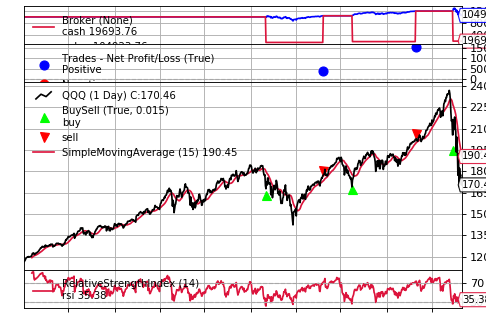

In [10]:
if __name__ == '__main__':
    df = pd.read_csv('./QQQ.csv',index_col='DATE',parse_dates=['DATE'])
    ticker = 'QQQ'
    data = bt.feeds.PandasData(dataname=df) #backtrader에서 사용할 수 있는 규격으로 변환
    
    cerebro = bt.Cerebro() #backtrader에서 실질적으로 전략을 움직이는 객체
    cerebro.addstrategy(TestStrategy) # 위에서 만든 전략을 추가
    cerebro.broker.setcommission(commission=0.001) # 거래수수료 설정
    cerebro.adddata(data,name=ticker) # 변환된 데이터 추가
    cerebro.broker.setcash(100000.0) # 보유 현금 액수 추가
    
    print('Starting Portfolio Value: %.2f' % (cerebro.broker.getvalue()))
    cerebro.run() #전략 수행
    print('Final Portfolio Value : %.2f' % (cerebro.broker.getvalue()))
    cerebro.plot(volume=False, savefig=True, path='./backtrader-plot2.png')